## Introduction 

This notebook will go over a new loss function to optimize the decision of the ERUPT metric directly for both single and mutliple response case.

1. New Loss Function for single response variable 

2. Building / Gridsearching the Uplift Model with new loss vs default mean-squared-error loss

3. Extending new loss function to multi-responses 



### New Loss Function  

Readers are encouraged to read the [example on single responses](https://github.com/Ibotta/ibotta_uplift/blob/master/examples/mr_uplift_one_response_example.ipynb) for a more thorough background on uplift models and the ERUPT metric. 

To recap we start with the decision function defined as: 

\begin{equation}
 \pi(x_i) =argmax \:_{t \in T} E[y_i | X=x_i, T=t]
\tag{1}
\end{equation}

This is the function that determines whether to assign a user a particular treatment for a single response we wish to maximize. It just says that we apply the treatment with the highest expected value.

To exaluate the decision function the ERUPT metric is used. It estimates the expected value of the decision function on an out-of-sample dataset. Assuming that the treatments are uniformly (all treatments have same number of observations) and randomly assigned the ERUPT metric is:

$$ERUPT(pi(x),y,t) \propto \sum_{i}^N y_i I(\pi(x_i) = t_i) \tag{2}$$



The original loss functions used in mr_uplift have used a mean squared error (MSE) function $f(x,t)$ to estimate $E[y_i | X=x_i, T=t]$ :


\begin{equation}
 MSE(y,f(x,t)) = 1/N \sum_{i}^N (y_i-f(X=x_i, T=t_i))^2
\tag{3}
\end{equation}


In theory this should produce an estimator that approximates the interaction between $x$ and $t$ neccesary to build a good decision function $\pi(x_i)$. However, in practice thie interaction effect is tricky to estimate because the it is generally small relative to main effects and noise in the response. Several researchers have developed in techniques order to estimate this (see [Zhao, Fang, Simchi-Levi](https://arxiv.org/pdf/1705.08492.pdf?source=post_page---------------------------), [Athey, Tibshirani, Wager](https://arxiv.org/pdf/1610.01271.pdf), [Hitsch, Misra](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3111957) to name a few).


The approach taken here follows an approach developed by [Weiss](https://medium.com/building-ibotta/maximizing-the-erupt-metric-for-uplift-models-f8d7e57bfdf2) and [Fernandez-Loria, et al](https://arxiv.org/pdf/2004.11532.pdf) in which it attempts to optimize the ERUPT function in $2$ directly. 

In order to approximate that function we assign a 'probability' score to each treatment: 


\begin{equation}
 optimizedloss(y,t,f(t,x)) =  \sum_{i}^N \sum_{t \in T}^T y_{i,t}*p(t|x_i)  =  \sum_{i}^N \sum_{t \in T}^T y_{i,t}*\frac{e^{f(X=x_i, T=t)}}{\sum_{t \in T}e^{f(X=x_i, T=t)}}
\tag{4}
\end{equation}
where $y_{i_t}$ is equal to $y_{i}$ if user $i$ recieved treatment $t$, else zero. 

One major difference here compared with [Weiss](https://medium.com/building-ibotta/maximizing-the-erupt-metric-for-uplift-models-f8d7e57bfdf2) is that it explitly incorporates the treatments in the function $f()$ to be estimated. This should help regularize the estimation if the treatments have similar meta-data information. For instance; if the treatments are ordered then this model can take that information into account.

Finally, MSE is also included in the loss function to create a weighted loss between the two. Including MSE should help when the estimated optimal treatment does not equal the treatment assignment:

\begin{equation}
\alpha*optimizedloss(y,t,f(t,x)) + (1-\alpha)*MSE(y,f(x,t))
\tag{5}
\end{equation}




In [1]:
from ggplot import *
import numpy as np
import pandas as pd

from mr_uplift.dataset.data_simulation import get_sin_uplift_data
from mr_uplift.mr_uplift import MRUplift


/Users/samweiss/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/samweiss/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
Using TensorFlow backend.


### Data Generating Process

In order to test the new loss function I simulated some data and compared results with a regular MSE loss. Below is the data generating process of the data. This is similar to the previous data function except that the treatment effect relationship is now in a sine function. This adds a layer of complexity for the model to estimate.

\begin{equation}
x_1  \sim runif(0,1)
\end{equation}

\begin{equation}
x_2 \sim runif(0,1)
\end{equation}

\begin{equation}
e_1 \sim rnorm(0,1)
\end{equation}

\begin{equation}
e_2 \sim rnorm(0,1)
\end{equation}

\begin{equation}
t \sim rbinom(.5)
\end{equation}

\begin{equation}
noise \sim rnorm(0,1)
\end{equation}

\begin{equation}
revenue = sin(20*x_1*t) + e_1
\end{equation}

\begin{equation}
costs = sin(20*x_2*t) + e_2
\end{equation}

\begin{equation}
profit = revenue - costs
\end{equation}




In [2]:
np.random.seed(23)

y, x, t = get_sin_uplift_data(10000)

y = pd.DataFrame(y)
y.columns = ['revenue','cost', 'noise']
y['profit'] = y['revenue'] - y['cost']

In [3]:
#Build Uplift with the default MSE Loss
uplift_model = MRUplift()
param_grid = dict(num_nodes=[8, 32], dropout=[.1,.25], activation=[
                          'relu'], num_layers=[2,3], epochs=[25], batch_size=[100])



uplift_model.fit(x, np.array(y['profit']).reshape(-1,1), t.reshape(-1,1), param_grid = param_grid, n_jobs = 1, cv = 5)

#Build Uplift with the Optimization Loss 
#alpha and copy_several_times are new hyperparameters. alpha is the weight given to MSE vs optimi_loss from eqn (5)
#copy_several_times is for multiple response uplift models and is described below
uplift_model_optimized = MRUplift()
param_grid_optimized = dict(num_nodes=[32,64], dropout=[.1,.25], activation=[
                          'relu'], num_layers=[2,3], epochs=[30], batch_size=[100],
                 copy_several_times = [None], 
                 alpha = [.999,.99,.75,.5])
uplift_model_optimized.fit(x, np.array(y['profit']).reshape(-1,1), t.reshape(-1,1),
                           param_grid = param_grid_optimized, n_jobs = 1, optimized_loss = True, cv=5)


### Results MSE vs Optimiziation 

The results below show the MSE only loss function increases profits by around ~0.08 while the new optimization results in profit score of ~0.26. This shows the new loss function can help estimate the heterogeneous effect more effectively in this example.  

In [4]:
erupt_curves_mse, distribution_mse = uplift_model.get_erupt_curves()
print('ERUPT Metric for MSE Model')
print(erupt_curves_mse)

print('Distribution of Treatments for MSE Model')
print(distribution_mse)

print('Best Parameters MSE')
print(uplift_model.best_params_net)


erupt_curves_optimized, distribution_optimized = uplift_model_optimized.get_erupt_curves()

print('ERUPT Metric for Optimized Model')
print(erupt_curves_optimized)

print('Distribution of Treatments for Optimized Model')
print(distribution_optimized)

print('Best Parameters Optimized')
print(uplift_model_optimized.best_params_net)


Using Test Data Set
ERUPT Metric for MSE Model
       mean       std response_var_names weights assignment
0  0.081891  0.009183              var_0       1      model
0 -0.003644  0.009587              var_0       1     random
Distribution of Treatments for MSE Model
   num_observations  tmt weights  percent_tmt
0              4915    0       1     0.702143
1              2085    1       1     0.297857
Best Parameters MSE
{'activation': 'relu', 'batch_size': 100, 'dropout': 0.25, 'epochs': 25, 'num_layers': 3, 'num_nodes': 8}
Using Test Data Set
ERUPT Metric for Optimized Model
       mean       std response_var_names weights assignment
0  0.266839  0.010255              var_0       1      model
0 -0.013514  0.011633              var_0       1     random
Distribution of Treatments for Optimized Model
   num_observations  tmt weights  percent_tmt
0              3985    0       1     0.569286
1              3015    1       1     0.430714
Best Parameters Optimized
{'activation': 'relu', '

### Multi-Response Optimization

See  [example on multiple_responses](https://github.com/Ibotta/ibotta_uplift/blob/master/examples/mr_uplift_multiple_response_example.ipynb) for a more detailed introduction on uplift models with multiple responses.


The general idea of uplift models with multiple response variables is to create a new variable that is a weighted sum of the responses. These weights define the relative importance responses variables. One can then calculate ERUPT metrics for a given set of weights as if it was a single response. 

However, issue of extending the loss function from $(4)$ to a multi-response framework is that it only optimizes one set of weights. Ideally we'd like maximize a function that 'integrates out' the weights. Instead of doing that explitily I draw a random uniform weight for each observation-response pair and maximize the following:

\begin{equation}
w_{i,j} \sim runif(-1,1)
\end{equation}

\begin{equation}
 optimizedlossmultioutput(y,t,w,f(t,x)) = \sum_{i}^N \sum_{t \in T}^T (\sum_{j}^J w_{i,j} y_{i,t,j})*\frac{e^{\sum_{j}^J w_{i,j} f_j(X=x_i, T=t)}}{\sum_{t \in T}e^{\sum_{j}^J w_{i,j} f_j(X=x_i, T=t)}}
\tag{6}
\end{equation}

Note that the weights $w_{i,j}$ do not explicitly go into the function $f(t,x)$. 

Different 'optimal treatments' will be selected due to randomness of the weights for two identical observations. Because of this I included another hyperparameter 'copy_several_times' that duplicates observations a specified number of times. I've found this to be helpful in practice

An MSE loss is also include similar to $(5)$. This has two main benefits 1) to create help estimate the function when the optimal treatment was not randomly assigned and 2) to maintain the order of response predictions. Becuase of these reasons I would not set $\alpha$ to be 1. 

Below is an example of the multi-response case.


In [5]:
uplift_model_optimized_mr = MRUplift()
param_grid = dict(num_nodes=[ 32,64, 256], dropout=[.25], activation=[
                          'relu'], num_layers=[3], epochs=[25], batch_size=[100],
                 copy_several_times = [10], 
                 alpha = [.999,.99,.5])

uplift_model_optimized_mr.fit(x, y, t.reshape(-1,1),
                           param_grid = param_grid, n_jobs = 1, optimized_loss = True, cv=5)


In [6]:
erupt_curves_optimized_mr, distribution_optimized_mr = uplift_model_optimized_mr.get_erupt_curves()

Using Test Data Set


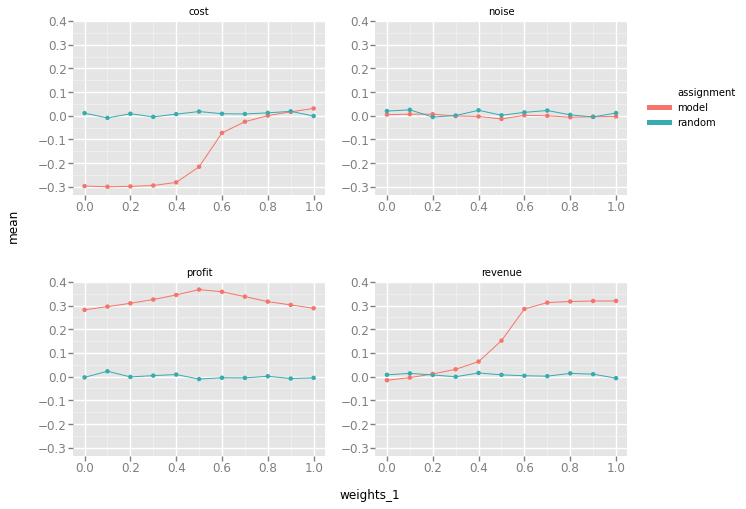

<ggplot: (-9223372036499994999)>

In [7]:
from ggplot import *

distribution_optimized_mr['weights_1'] = [np.float(x.split(',')[0]) for x in distribution_optimized_mr['weights']]
erupt_curves_optimized_mr['weights_1'] = [np.float(x.split(',')[0]) for x in erupt_curves_optimized_mr['weights']]

ggplot(aes(x='weights_1', y='mean', group = 'assignment', colour = 'assignment'), data=erupt_curves_optimized_mr) +\
    geom_line()+\
    geom_point()+facet_wrap("response_var_names")